# RSVP Response Prediction for New Tech Meetups

---

## Import libraries and read data

In [182]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.externals import joblib
from sklearn.model_selection import RandomizedSearchCV
import itertools
from gensim.models import Word2Vec
from scipy.stats import randint, expon
import seaborn as sns
import json
import warnings
%matplotlib inline

In [183]:
events = pd.read_json('../Data/events.json')
groups = pd.read_json('../Data/groups.json')
users = pd.read_json('../Data/users.json')
venues = pd.read_json('../Data/venues.json')

---

## Minimum Viable Product

Docker has been chosen as a way of ensuring dependencies are available in the remote environment. To minimise problems with ensuring the solution works with Docker, getting the simplest possible model (MVP) running in it was prioritised.

### Building the MVP dataset

The events dataset contains our target variable of number of RSVPs. It also contains at least 1 feature (*rsvp_limit*) that can be used to predict number of RSVPs, so we can create a minimum viable product just from this dataset.

In [184]:
events[0:3]

,created,description,duration,group_id,name,rsvp_limit,rsvps,status,time,venue_id
0,1309088803000,"<p><img src=""http://photos2.meetupstatic.com/p...",NaN,INTERNATIONALS-in-Rotterdam,INTERNATIONALS meet INTERNATIONALS- Midsummer ...,NaN,"[{'guests': 0, 'when': 1309881442000, 'respons...",past,1.310056e+12,68572
1,1439890905000,<p>'s Avonds je laptop openklappen om iets leu...,NaN,codecave,Let's code some fun stuff!,12.0,"[{'guests': 0, 'when': 1439922626000, 'respons...",upcoming,1.448476e+12,67856
2,1287573554000,"<p>dear members,</p> <p>Friday 5th of November...",NaN,Digital-Museum-Network-Amsterdam,Presentation of new applications/projects,12.0,"[{'guests': 0, 'when': 1288771966000, 'respons...",past,1.288962e+12,67870


Filter out any events that haven't happened yet as we can't know the final RSVP number for these

In [185]:
print("Number of events: %i" % len(events))
print("Number of events in past: %i" % (events.status == 'past').sum())
events = events[events.status == 'past']

Number of events: 6200
Number of events in past: 5628


Parse the count of positive RSVPs from the *rsvps* field

In [186]:
def parse_rsvp(rsvp_json):
    return sum([e['response']=='yes' for e in rsvp_json])

events['rsvp_yes'] = events.rsvps.apply(lambda x: parse_rsvp(x))

Infill null values in *rsvp_limit* - we will choose to infill with the max observed value in case we want to use a model type that will treat it as a continuous feature.

In [187]:
maxRsvpLimit = selected_data.rsvp_limit.max()
events['rsvp_limit'].fillna(maxRsvpLimit, inplace=True)

This is the dataset the MVP model will be trained on:

In [188]:
selected_data = events[['rsvp_yes','rsvp_limit']]
selected_data[0:3]

,rsvp_yes,rsvp_limit
0,45,500.0
2,5,12.0
3,79,100.0


Now we define our training and testing sets

In [189]:
X = selected_data.drop('rsvp_yes', axis=1)
Y = selected_data['rsvp_yes']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.75)
print("%i records in the training set" % Y_train.count())
print("%i records in the testing set" % Y_test.count())

4221 records in the training set
1407 records in the testing set


### MVP model

Random forests are usually decent catch-all models that don't take too long to train and handle well discontinuities and skews in the data.

In [190]:
rf = RandomForestRegressor()
rf.fit(X_train, Y_train)

r2_train = r2_score(Y_train, rf.predict(X_train))
r2_test = r2_score(Y_test, rf.predict(X_test))

print("R-square train: %f" % r2_train)
print("R-square test: %f" % r2_test)

R-square train: 0.375100
R-square test: 0.323312


We persist the trained model so we can use it to develop the scoring API part of the MVP. We also save the names of the required fields so the API can return a useful error if any fields are missing from the request.

Discussion of the details of the scoring API is outside of the scope of this presentation.

In [191]:
joblib.dump(rf, '../Data/rf.pkl')

required_fields = ['rsvp_limit']
joblib.dump(required_fields, '../Data/required_fields.pkl')

['../Data/required_fields.pkl']

----

## Data Familiarisation

Time to see what the rest of the data looks like..

### Inspect remaining datasets

In [192]:
users[0:2]

,city,country,hometown,memberships,user_id
0,London,gb,None,"[{'joined': 1401194987000, 'group_id': 'online...",45734
1,London,gb,None,"[{'joined': 1400505160000, 'group_id': 'online...",66261


In [193]:
groups[0:2]

,city,created,description,group_id,lat,link,lon,name,topics
0,Den Haag,1386377741000,<p>This group is focused on software architect...,Software-Architecture-and-Project-Design-The-H...,52.080002,http://www.meetup.com/Software-Architecture-an...,4.28,Software Architecture and Project Design The H...,"[WCF, Project Planning, Leadership, Software E..."
1,Amsterdam,1352707128000,<p>FP AMS aims to bring together commercial us...,fp-ams,52.369999,http://www.meetup.com/fp-ams/,4.89,FP AMS,"[Scala Play Framework, Functional Programming,..."


In [194]:
venues[0:2]

,city,country,lat,lon,name,venue_id
0,Groningen,nl,53.214241,6.569170,FabLab / Launchcafé,67082
1,London,gb,51.520836,-0.090599,The Brewery,67083


In [195]:
events[0:2]

,created,description,duration,group_id,name,rsvp_limit,rsvps,status,time,venue_id,rsvp_yes
0,1309088803000,"<p><img src=""http://photos2.meetupstatic.com/p...",NaN,INTERNATIONALS-in-Rotterdam,INTERNATIONALS meet INTERNATIONALS- Midsummer ...,500.0,"[{'guests': 0, 'when': 1309881442000, 'respons...",past,1.310056e+12,68572,45
2,1287573554000,"<p>dear members,</p> <p>Friday 5th of November...",NaN,Digital-Museum-Network-Amsterdam,Presentation of new applications/projects,12.0,"[{'guests': 0, 'when': 1288771966000, 'respons...",past,1.288962e+12,67870,5


### Inspect distribution of the target variable

Depending on the type of model we choose, this could be important e.g. for a Poisson distribution (which this looks like it is)  we would want to use this information to set the link function of a generalised linear model (GLM). Or we might want either to  avoid using some model types e.g. a linear SVM, or perhaps perform a log transform.

In this case, our random forest continues to be a decent choice - although we could consider a nonlinear SVM.

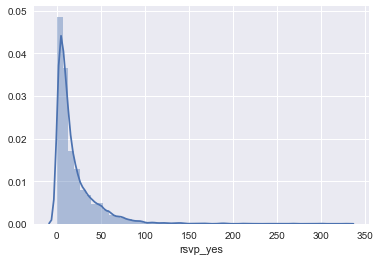

In [196]:
sns.distplot(Y)

Let's just check the distribution of *rsvp_limit* as that's likely to be an important feature...

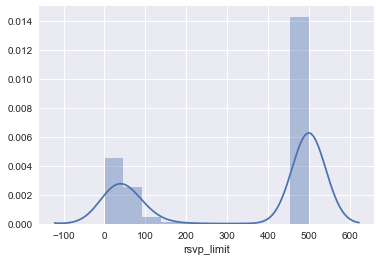

In [197]:
sns.distplot(X.rsvp_limit)

A model type that copes gracefully with discontinuities will help us here.

---

----

## Feature engineering

The features chosen to investigate are based on a balance of their supposed effectiveness and the ease with which they could be created. They are:
* Rsvp_limit - the maximum number of YES RSVPs that this event will allow
* Duration - the duration of the event, in seconds
* Group_member_count - the number of members of a group as at the time of event creation
* TimeFromCreationToEvent - the time from event creation to the time of the event
* Topic vectors - the topics of the groups, vectorised with Word2Vec

There are many potential features to explore which, due to time contraints are not possible in the current context. Some examples are:
* More vectorised text fields - group description, event description
* Features based on city name - e.g. number of groups and members in each city
* Geographic features - e.g. distance from group to venue, distance of venue to centroid of other venues in the city
* Features based on member hometown - the group count feature that we created could be modified to take into account how many of the members of the group live in the same city as the venue
* Features derived from group home-page e.g. vectorised text of home page; search rank of page for a query based on group topics
* Features based on group competition - is there another event at a similar time in a similar location with a similar topic vector?

---

### Group membership count

Each cell in the memberships column consists of a sequence of dictionaries.

In [198]:
users[5:6].memberships.values

array([ [{'joined': 1404716220000, 'group_id': 'DomCode'}, {'joined': 1425280166000, 'group_id': 'Utrecht-JavaScript-Meetup'}]], dtype=object)

We parse out the 'joined' and 'group_id' elements so that we have series of lists of these features. Then we flatten those series to form a new dataset - *memberships*.

In [199]:
memb_joined = users.memberships.apply(lambda membs: [m['joined'] for m in membs]).values
memb_group_id = users.memberships.apply(lambda membs: [m['group_id'] for m in membs]).values
memb_user = users.apply(lambda row: [row.user_id for m in row.memberships], axis=1).values
memberships = pd.DataFrame({'user_id':list(itertools.chain.from_iterable(memb_user)),
                           'joined':list(itertools.chain.from_iterable(memb_joined)),
                           'group_id':list(itertools.chain.from_iterable(memb_group_id))})

In [200]:
memberships[0:2]

,group_id,joined,user_id
0,onlineoptimizers,1401194987000,45734
1,onlineoptimizers,1400505160000,66261


Memberships per group will be needed for scoring, but to use this data for training we must filter out any group memberships from after the event creation date.

In [201]:
memberships_per_group = memberships.groupby('group_id')['user_id'].count().sort_values(ascending=False)
memberships_per_group[0:10]

group_id
Appsterdam                           3516
Hackers-and-Founders-Amsterdam-NL    3125
ocamsterdam                          2887
PermanentBeta                        2528
sensemakersams                       2146
INTERNATIONALS-in-Rotterdam          2042
mangrove                             1940
SMC050                               1728
OpenCoffeeDenHaag                    1606
StartupWeekendAmsterdam              1525
Name: user_id, dtype: int64

In [202]:
events['event_id'] = events.index
events_with_users = events[['event_id','group_id','created']].merge(memberships)
events_with_users[events_with_users.created > events_with_users.joined]
events_with_users[0:3]

,event_id,group_id,created,joined,user_id
0,0,INTERNATIONALS-in-Rotterdam,1309088803000,1314890908000,40788
1,0,INTERNATIONALS-in-Rotterdam,1309088803000,1397202355000,20344
2,0,INTERNATIONALS-in-Rotterdam,1309088803000,1263579736000,42459


In [203]:
group_member_count = events_with_users.groupby('event_id')['group_id'].count()

In [204]:
events['group_member_count'] = group_member_count
events[0:2][['group_id', 'event_id', 'group_member_count']]

,group_id,event_id,group_member_count
0,INTERNATIONALS-in-Rotterdam,0,2042
2,Digital-Museum-Network-Amsterdam,2,423


---

### Time from creation to event

In [205]:
events['timeFromCreationToEvent'] = events.time - events.created

---

### Topic vectors

Some topics are more interesting than others. To find out if this effects event popularity we will vectorise the topics using Word2Vec. Unlike Doc2Vec, Word2Vec uses a bag-of-words approach (which fits the topics data). While topics can have more than one word, we will treat each topic string as its own token.

We will train at event level rather than group level so that we don't face any complications with our train/test split (the Word2Vec model should be trained on the training set only).

In [213]:
 events['topics'] = events.merge(groups, on='group_id').sort_values('event_id').set_index('event_id').topics

We will demonstrate the approach on the groups data. It will be re-applied after we have made the train/test split.

In [179]:
vecSize = 5 #number of features to create
w2vModel = Word2Vec(groups.topics, size=vecSize, min_count=1)

In [180]:
groups.topics[0]

['WCF',
 'Project Planning',
 'Leadership',
 'Software Engineering',
 'Enterprise Architecture',
 'Software Development',
 '.NET',
 'IDesign Method',
 'Windows Azure Platform',
 'Software Architecture']

The vector for one topic:

In [164]:
w2vModel.wv['Project Planning']

array([ 0.02116362,  0.06245093,  0.02922328,  0.07918563, -0.02173011], dtype=float32)

The mean of the vectors for all topics in a group:

In [165]:
[w2vModel.wv[topic] for topic in groups.topics[0:1]][0].mean(axis=0)

array([-0.0431071 ,  0.03123486,  0.02339208, -0.09654646, -0.13693124], dtype=float32)

#### Helper functions for vectorising topics

In [166]:
def vectorise_topics(group_topics):
    wvecs = []
    for topic in group_topics:
        try:
            wvecs.append(w2vModel.wv[topic])
        except:
            None
    result = np.vstack(wvecs).mean(axis=0) if len(wvecs)>0 else np.zeros(vecSize)
    return result  

In [167]:
vectorise_topics(['Expat', 'Social Networking', 'Rotterdam', 'Happy Hour', 'The Netherlands', 'Not a real topic'])    

array([-0.0566151 ,  0.00828698,  0.03514945, -0.08435114, -0.07341819], dtype=float32)

In [168]:
def vectorise_topics_vectorised(events):
    vectorised_topics = np.vstack(events.topics.apply(lambda x: vectorise_topics(x)))
    for idx in range(vectorised_topics.shape[1]):
        events['topicvec_' + str(idx)] = vectorised_topics[:,idx]
    return events
        
vectorise_topics_vectorised(groups)[0:2]

,city,created,description,group_id,lat,link,lon,name,topics,topicvec_0,topicvec_1,topicvec_2,topicvec_3,topicvec_4
0,Den Haag,1386377741000,<p>This group is focused on software architect...,Software-Architecture-and-Project-Design-The-H...,52.080002,http://www.meetup.com/Software-Architecture-an...,4.28,Software Architecture and Project Design The H...,"[WCF, Project Planning, Leadership, Software E...",-0.043107,0.031235,0.023392,-0.096546,-0.136931
1,Amsterdam,1352707128000,<p>FP AMS aims to bring together commercial us...,fp-ams,52.369999,http://www.meetup.com/fp-ams/,4.89,FP AMS,"[Scala Play Framework, Functional Programming,...",-0.020570,0.043243,0.034153,-0.090444,-0.076920


---

## Training the final model

Here is our final dataset, with the topics yet to be vectorised:

In [214]:
required_fields = ['rsvp_limit','duration','timeFromCreationToEvent','group_member_count', 'topics']
selected_events = events[events.status == 'past'][required_fields + ['rsvp_yes']]
selected_events['duration'].fillna(-1, inplace=True)
selected_events[0:5]

,rsvp_limit,duration,timeFromCreationToEvent,group_member_count,topics,rsvp_yes
0,500.0,-1.0,9.673970e+08,2042,"[Expat, Social Networking, Rotterdam, Happy Ho...",45
2,12.0,-1.0,1.388446e+09,423,"[Historical Museum, Web Technology, Museum, Ne...",5
3,100.0,10800000.0,1.031852e+10,497,"[Innovation, Product Development, Lean Startup...",79
4,500.0,-1.0,1.827191e+09,344,"[gamification at work, Engagement Design, Ente...",17
5,500.0,16200000.0,5.799950e+08,28,"[E Commerce, E-Commerce, Bio, Online Marketing...",3


### Model build and evaluation helper functions

Define search space for hyperparameter search.

In [216]:
param_dist_rf = {"max_depth": [3, None],
              #"max_features": randint(1, len(X_train.columns)),
              "min_samples_split": randint(2, 11),
              "min_samples_leaf": randint(1, 11),
              "n_estimators": randint(1, 100),
              "bootstrap": [True, False],
              #"criterion": ["gini", "entropy"]
                }

param_dist_svm = {'C': expon(scale=10),
                  'gamma': expon(scale=1),
                  'kernel': ['rbf', 'linear']}

Define randomised hyperparameter search for a support vector regression and a random forest regression

In [218]:
rfr = RandomForestRegressor()
svr = SVR()
svr_search = RandomizedSearchCV(svr, param_distributions=param_dist_svm, n_iter=2)
rfr_search = RandomizedSearchCV(rfr, param_distributions=param_dist_rf, n_iter=20)

Evaluation function that tells us the R-squared for training and testing sets

In [223]:
def evaluate(model, X_train, X_test, Y_train, Y_test, plots=True):
    print("Parameters of best model:\n %s" % model.get_params())
    
    if plots:
        plotDf = pd.DataFrame({'y': Y_test, 'yhat': model.predict(X_test)})
        sns.jointplot(x="yhat", y="y", data=plotDf)

    r2_train = r2_score(Y_train, model.predict(X_train))
    r2_test = r2_score(Y_test, model.predict(X_test))
    print("\nR-square train: %f" % r2_train)
    print("R-square test: %f" % r2_test)
    
    if type(model) == RandomForestRegressor:
        print("\n")
        print(pd.DataFrame({'features': X_train.columns, 'importances': model.feature_importances_}). \
        sort_values('importances', ascending=False))
    
    return None

### Run the model

4221 records in the training set
1407 records in the testing set
Parameters of best model:
 {'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 9, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 60, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

R-square train: 0.888540
R-square test: 0.735135


                  features  importances
3       group_member_count     0.244935
0               rsvp_limit     0.244651
6               topicvec_2     0.142592
2  timeFromCreationToEvent     0.098841
7               topicvec_3     0.080474
4               topicvec_0     0.058360
5               topicvec_1     0.051007
1                 duration     0.041612
8               topicvec_4     0.037528


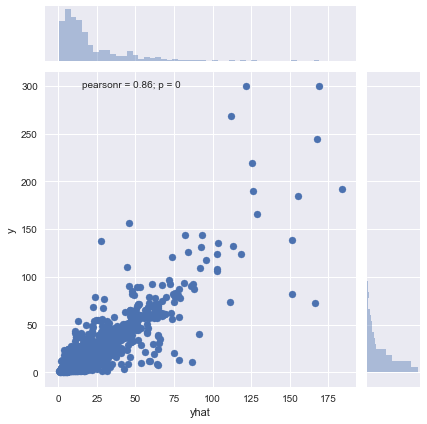

In [222]:
warnings.filterwarnings('ignore')
X = selected_events.drop('rsvp_yes', axis=1)
Y = selected_events['rsvp_yes']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.75)
print("%i records in the training set" % Y_train.count())
print("%i records in the testing set" % Y_test.count())

w2vModel = Word2Vec(X_train.topics, size=vecSize, min_count=1)
X_train = vectorise_topics_vectorised(X_train).drop('topics', axis=1)
X_test = vectorise_topics_vectorised(X_test).drop('topics', axis=1)

rfr_search.fit(X_train, Y_train)
evaluate(rfr_search.best_estimator_, X_train, X_test, Y_train, Y_test, plots=True)

---

## Create scorer

These are the objects we will need to score new data with

In [224]:
scorObj = {'rfr_search': rfr_search,
            'memberships_per_group': memberships_per_group,
            'maxRsvpLimit': maxRsvpLimit,
            'w2vModel': w2vModel,
            'required_fields': required_fields,
          'vecSize':vecSize}
#joblib.dump(scorObj, '../Data/scoring_objects.pkl')

Create an example query to test the scorer with

In [228]:
with open('../Data/events.json') as f:
    events_example = json.load(f)[0]
    
with open('../Data/groups.json') as f:
    groups_example = json.load(f)[0]
    
required_fields = ['rsvp_limit','duration','time','created','group_id','topics']
example_query = {k:v for k,v in {**groups_example, **events_example}.items() if k in required_fields}

example_query

{'created': 1309088803000,
 'duration': None,
 'group_id': 'INTERNATIONALS-in-Rotterdam',
 'rsvp_limit': None,
 'time': 1310056200000,
 'topics': ['WCF',
  'Project Planning',
  'Leadership',
  'Software Engineering',
  'Enterprise Architecture',
  'Software Development',
  '.NET',
  'IDesign Method',
  'Windows Azure Platform',
  'Software Architecture']}

Define a class that creates features from a query and predicts the number of RSVPs

In [229]:
class model:
    def __init__(self, rfr_search, memberships_per_group, maxRsvpLimit, w2vModel):
        self.rfr_search = rfr_search
        self.memberships_per_group = memberships_per_group
        self.maxRsvpLimit = maxRsvpLimit
        self.w2vModel = w2vModel
    
    def vectorise_topics(self, group_topics):
        wvecs = []
        for topic in group_topics:
            try:
                wvecs.append(self.w2vModel.wv[topic])
            except:
                None
        result = np.vstack(wvecs).mean(axis=0) if len(wvecs)>0 else np.zeros(vecSize)
        return result  

    def score(self, query):
        record_to_score = np.hstack([np.array([query['rsvp_limit'] if query['rsvp_limit'] else self.maxRsvpLimit,
                                           query['duration'] if query['duration'] else -1,
                                           query['time'] - query['created'],
                                           self.memberships_per_group[query['group_id']]]),
                                 vectorise_topics(example_query['topics'])]).reshape(1, -1)
        prediction = int(round(self.rfr_search.best_estimator_.predict(record_to_score)[0]))
        return prediction

In [230]:
modelInstance = model(scorObj['rfr_search'], scorObj['memberships_per_group'], scorObj['maxRsvpLimit'], scorObj['w2vModel'])
modelInstance.score(example_query)

76